In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import corner
import os
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
plt.rcParams['font.size'] = 20

notebook_direc = os.getcwd()
samples_direc = notebook_direc + "/../../MCMC_FM_Data"
run_direc = samples_direc + "/PE_samples"

FM_direc = samples_direc + "/fisher_matrices"

In [2]:
def load_samples_h5(file_path):
    with h5py.File(file_path, "r") as f:
        # Load parameter labels
        param_labels = [label.decode('utf-8') if isinstance(label, bytes) else label
                        for label in f["param_labels"][()]]

        # Load true values
        true_vals = f["true_values"][()]

        # Load samples into a dictionary
        samples_dict = {}
        for label in param_labels:
            samples_dict[label] = f[f"samples/{label}"][()]

    return samples_dict, param_labels, true_vals

In [3]:

# Identify path of samples for case_1 in FEW paper
file_path_case_1 = run_direc + "/Case_1_EMRI_prograde" + '/prograde_EMRI_case_1_1eneg5.h5'

# Extract processed samples for case_1, parameter labels and the true parameters
burned_samples_dict_case_1, param_labels, true_vals_EMRI_case_1 =  load_samples_h5(file_path_case_1)

# Extract as list
burned_samples_EMRI_case_1 = list(burned_samples_dict_case_1.values())

N_params = len(param_labels)

# Extract mean and 1sigma deviations of processed MCMC chains
std_vecs = [np.std(burned_samples_EMRI_case_1[j]) for j in range(N_params)]
mean_vecs = np.array([np.mean(burned_samples_EMRI_case_1[j]) for j in range(N_params)])

# Extrat Fisher matrix computation
fname = FM_direc + "/case_1/Fisher_case_1.h5"
with h5py.File(fname, "r") as f:
    FM = f["Fisher"][:,:]
    
# Compute approximation to parameter covariance matrix
Cov_Matrix = np.linalg.inv(FM)

# Now generate samples from the approximated Fisher matrix
FM_approx_samples = np.random.multivariate_normal(mean_vecs, Cov_Matrix, len(burned_samples_EMRI_case_1[0]))

# Posterior variance comparison


In [4]:
# Quantitative Goodness of Fit Analysis
# Compare Fisher Matrix approximation vs MCMC samples

import warnings
warnings.filterwarnings('ignore')

print("=" * 70)
print("QUANTITATIVE GOODNESS OF FIT ANALYSIS")
print("=" * 70)

# 1. Parameter-wise comparison
print("\n1. PARAMETER-WISE COMPARISON:")
print("-" * 80)
print(f"{'Parameter':<18} {'MCMC σ':<18} {'FM σ':<18} {'σ Ratio':<15}")
print("-" * 80)

mcmc_stds = []
fm_stds = []

for i, param in enumerate(param_labels):
    mcmc_mean = np.mean(burned_samples_EMRI_case_1[i])
    mcmc_std = np.std(burned_samples_EMRI_case_1[i])
    fm_mean = np.mean(FM_approx_samples[:, i])
    fm_std = np.std(FM_approx_samples[:, i])
    
    mcmc_stds.append(mcmc_std)
    fm_stds.append(fm_std)
    
    std_ratio = fm_std / mcmc_std if mcmc_std != 0 else np.inf
    
    print(f"{param:<18} {mcmc_std:<18.4e} {fm_std:<18.4e} {std_ratio:<15.3f}")

mcmc_stds = np.array(mcmc_stds)
fm_stds = np.array(fm_stds)

QUANTITATIVE GOODNESS OF FIT ANALYSIS

1. PARAMETER-WISE COMPARISON:
--------------------------------------------------------------------------------
Parameter          MCMC σ             FM σ               σ Ratio        
--------------------------------------------------------------------------------
$M/M_{\odot}$      8.3227e-01         8.1852e-01         0.983          
$\mu/M_{\odot}$    1.1399e-05         1.0981e-05         0.963          
$a$                2.3269e-07         2.2174e-07         0.953          
$p_{0}$            3.1193e-06         3.0713e-06         0.985          
$e_{0}$            1.5803e-07         1.5276e-07         0.967          
$D_{s}/Gpc$        8.4940e-02         8.3070e-02         0.978          
$\theta_{S}$       2.8403e-03         2.8054e-03         0.988          
$\phi_{S}$         2.7745e-03         2.7006e-03         0.973          
$\theta_{K}$       2.3351e-02         2.2953e-02         0.983          
$\phi_{K}$         2.2755e-02         2

# Corner plot

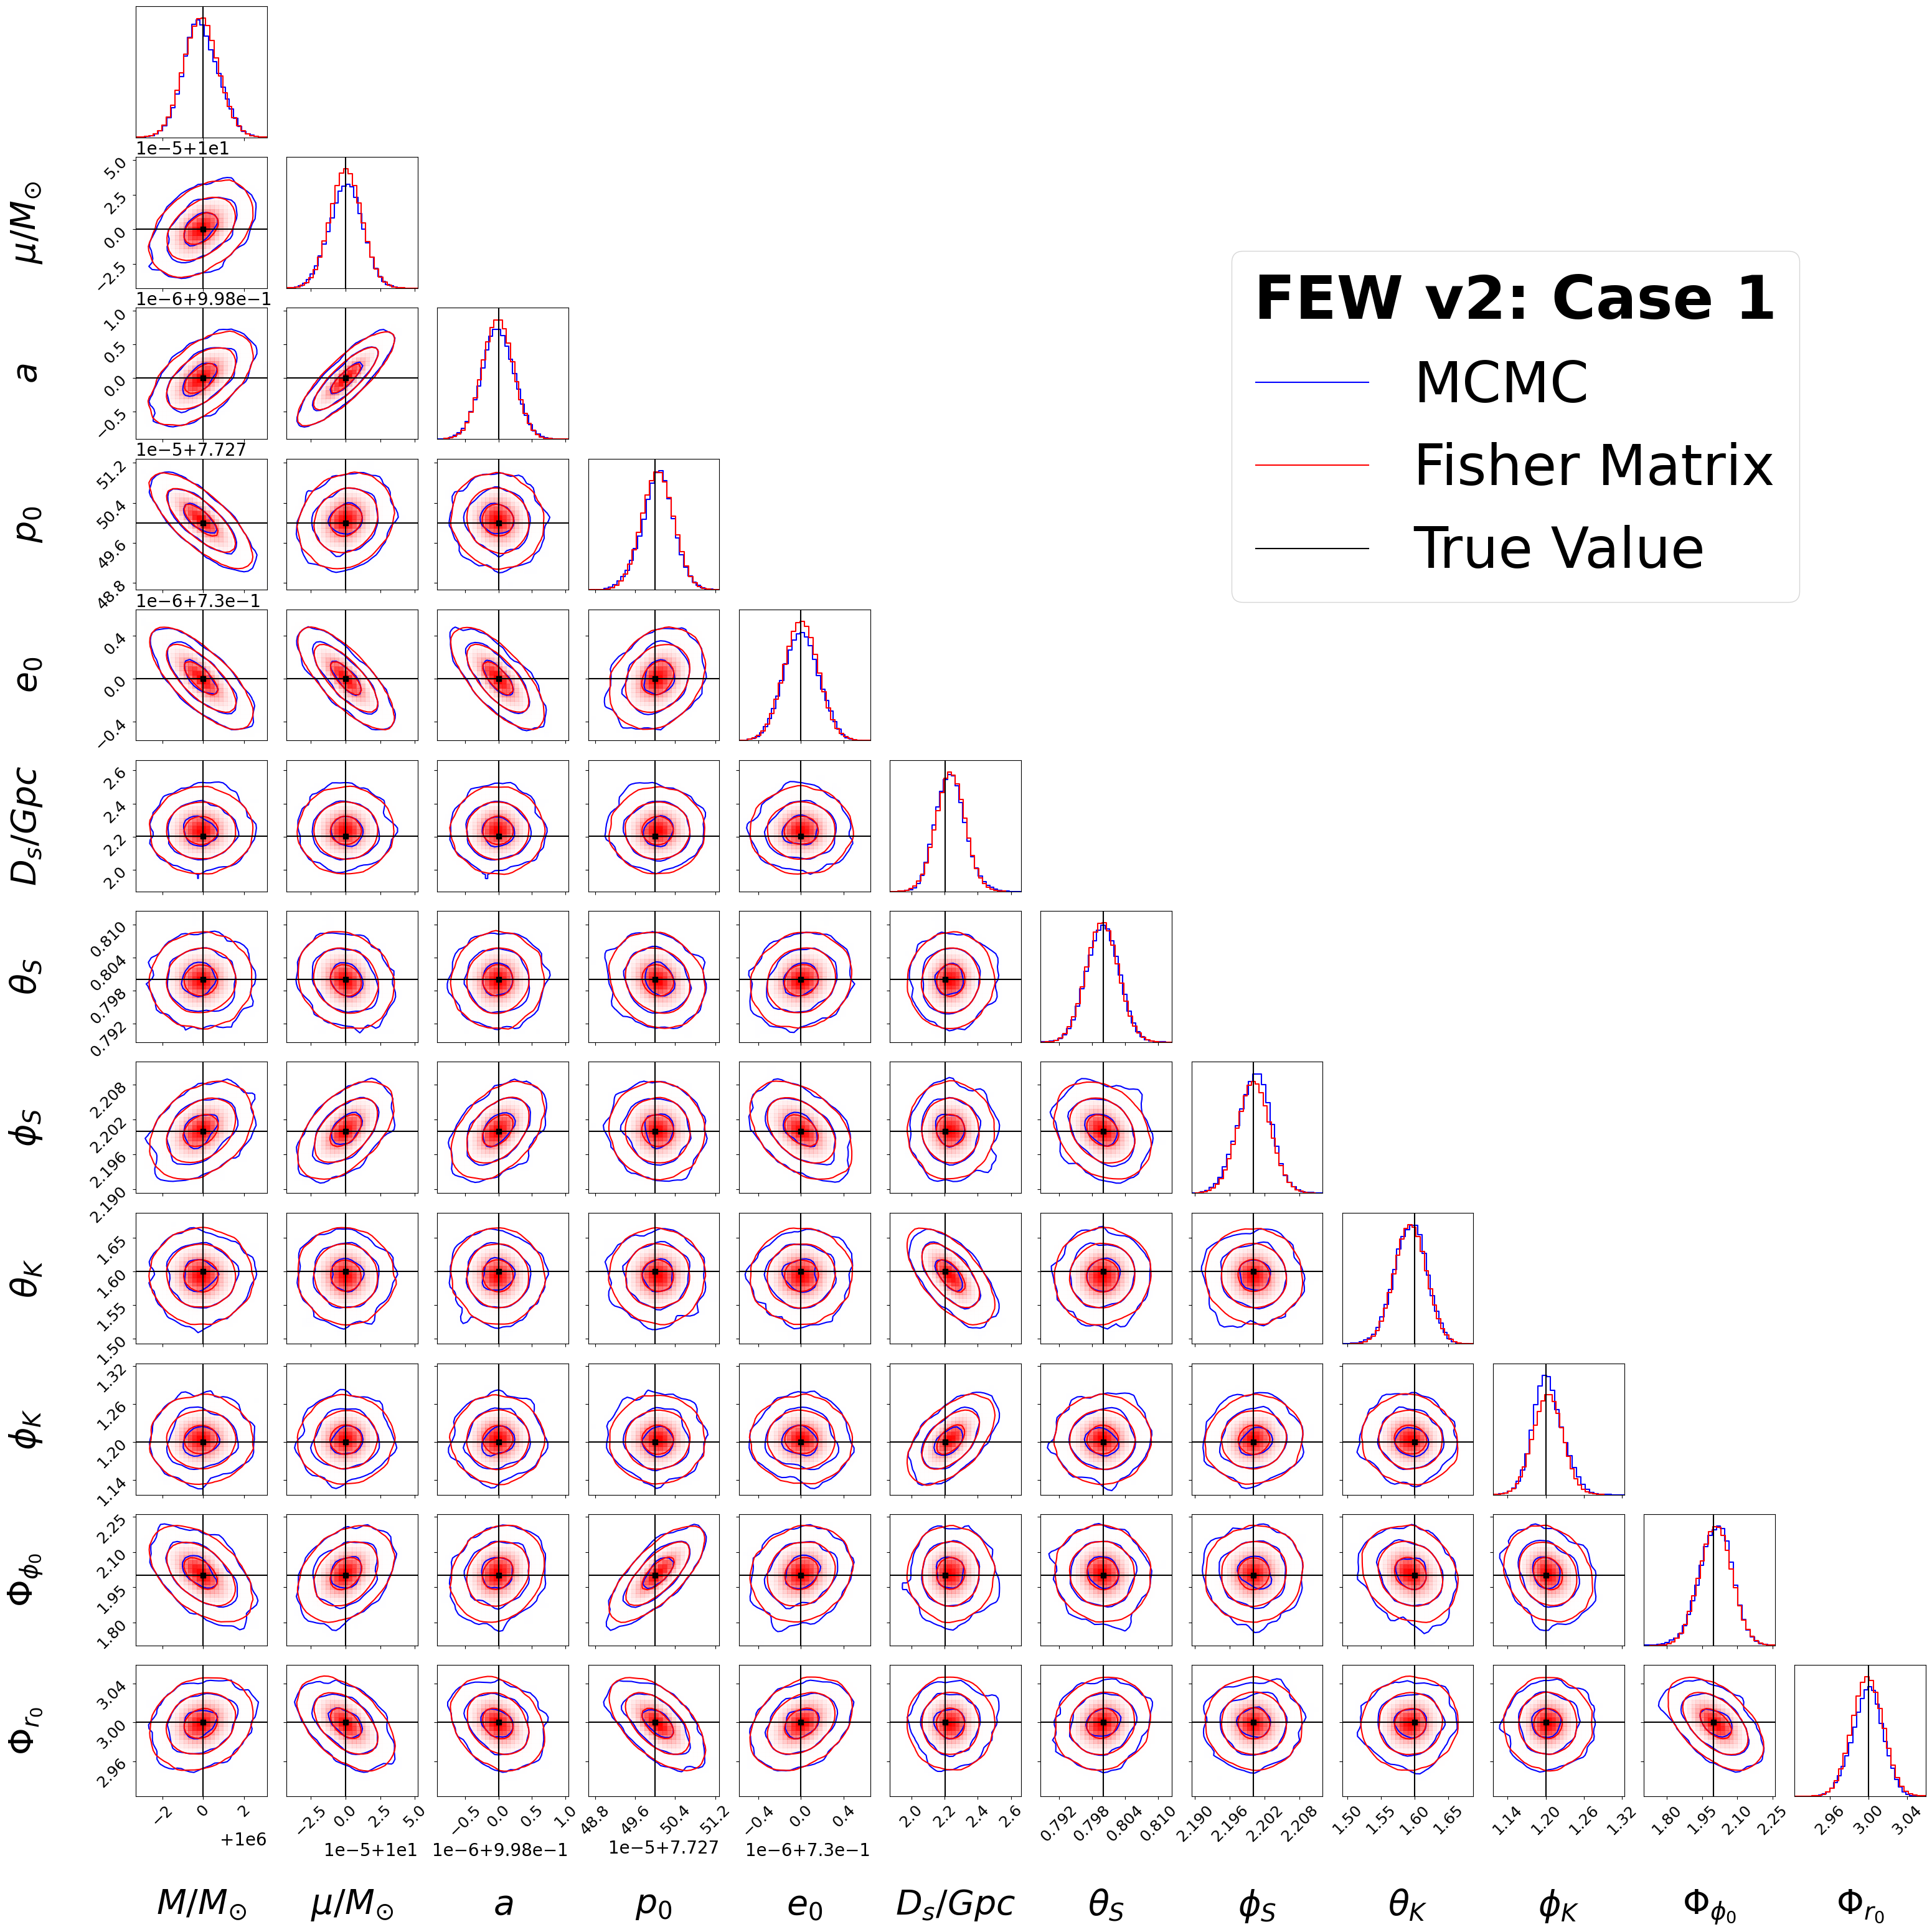

In [5]:
# Build corner kwargs
corner_kwargs = dict(plot_datapoints=False,smooth1d=True,
                       labels=param_labels, levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)), 
                       label_kwargs=dict(fontsize=40), max_n_ticks=4,
                       show_titles=False, smooth = True, labelpad = 0.4)

# Reshape for corner plot
samples_corner_1eneg5 = np.column_stack(burned_samples_EMRI_case_1)

# plot a corner plot of the 1 and 2D marginalised distributions from MCMC analysis
figure = corner.corner(samples_corner_1eneg5,bins = 30, color = 'blue', **corner_kwargs)

# plot a corner plot of the 1 and 2D marginalised distributions approximated via FM
corner.corner(FM_approx_samples, fig = figure, bins = 30, color = 'red', **corner_kwargs)

axes = np.array(figure.axes).reshape((N_params, N_params))

# True parameters for 1D marginals
for i in range(N_params):
    ax = axes[i, i]
    ax.axvline(true_vals_EMRI_case_1[i], color="k")

# True parameters for 2D marginals
for yi in range(N_params):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axhline(true_vals_EMRI_case_1[yi], color="k")
        ax.axvline(true_vals_EMRI_case_1[xi],color= "k")
        ax.plot(true_vals_EMRI_case_1[xi], true_vals_EMRI_case_1[yi], "sk")

for ax in figure.get_axes():
    ax.tick_params(axis='both', labelsize=18)
# For legend -- show true params, MCMC, FM samples
blue_line = mlines.Line2D([], [], color='blue', label=r'MCMC')
red_line = mlines.Line2D([], [], color='red', label=r'Fisher Matrix')
black_line = mlines.Line2D([], [], color='black', label='True Value')

# Plot legend
plt.legend(handles=[blue_line, red_line, black_line], fontsize = 65, frameon = True, bbox_to_anchor=(0.25, N_params), loc="upper right", title = "FEW v2: Case 1", title_fontproperties = FontProperties(size = 70, weight = 'bold'))
plt.subplots_adjust(left=-0.1, bottom=-0.1, right=None, top=None, wspace=0.15, hspace=0.15)


# KL, KS and JS divergence checks

In [6]:
from scipy.stats import entropy, gaussian_kde
from scipy.spatial.distance import jensenshannon

# 2. KL Divergence and Jensen-Shannon Divergence Analysis
print("\n2. DIVERGENCE ANALYSIS:")
print("-" * 70)

kl_divergences = []
js_divergences = []
ks_statistics = []

# For each parameter, compute divergences
for i, param in enumerate(param_labels):
    mcmc_samples = burned_samples_EMRI_case_1[i]
    fm_samples = FM_approx_samples[:, i]
    
    # Create probability density estimates using KDE
    try:
        # Use KDE to estimate probability densities
        mcmc_kde = gaussian_kde(mcmc_samples)
        fm_kde = gaussian_kde(fm_samples)
        
        # Create common evaluation points
        min_val = min(np.min(mcmc_samples), np.min(fm_samples))
        max_val = max(np.max(mcmc_samples), np.max(fm_samples))
        eval_points = np.linspace(min_val, max_val, 1000)
        
        # Evaluate PDFs
        mcmc_pdf = mcmc_kde(eval_points)
        fm_pdf = fm_kde(eval_points)
        
        # Normalize to ensure they sum to 1 (for discrete approximation)
        mcmc_pdf = mcmc_pdf / np.sum(mcmc_pdf)
        fm_pdf = fm_pdf / np.sum(fm_pdf)
        
        # Add small epsilon to avoid log(0)
        epsilon = 1e-10
        mcmc_pdf = mcmc_pdf + epsilon
        fm_pdf = fm_pdf + epsilon
        
        # Calculate KL divergence: D_KL(MCMC || FM)
        kl_div = entropy(mcmc_pdf, fm_pdf)
        kl_divergences.append(kl_div)
        
        # Calculate Jensen-Shannon divergence (symmetric)
        js_div = jensenshannon(mcmc_pdf, fm_pdf)
        js_divergences.append(js_div)
        
        # Kolmogorov-Smirnov test
        from scipy.stats import ks_2samp
        ks_stat, ks_pvalue = ks_2samp(mcmc_samples, fm_samples)
        ks_statistics.append(ks_stat)
        
        print(f"{param:<20} KL: {kl_div:<10.4f} JS: {js_div:<10.4f} KS: {ks_stat:<10.4f}")
        
    except Exception as e:
        print(f"{param:<20} Error in divergence calculation: {str(e)[:30]}...")
        kl_divergences.append(np.nan)
        js_divergences.append(np.nan)
        ks_statistics.append(np.nan)

# Summary statistics
print(f"\nDIVERGENCE SUMMARY:")
print(f"Mean KL divergence:  {np.nanmean(kl_divergences):.4f}")
print(f"Mean JS divergence:  {np.nanmean(js_divergences):.4f}")
print(f"Mean KS statistic:   {np.nanmean(ks_statistics):.4f}")


2. DIVERGENCE ANALYSIS:
----------------------------------------------------------------------
$M/M_{\odot}$        KL: 0.0045     JS: 0.0333     KS: 0.0231    


$\mu/M_{\odot}$      KL: 0.0034     JS: 0.0285     KS: 0.0179    
$a$                  KL: 0.0038     JS: 0.0293     KS: 0.0174    


$p_{0}$              KL: 0.0047     JS: 0.0335     KS: 0.0173    
$e_{0}$              KL: 0.0030     JS: 0.0271     KS: 0.0154    


$D_{s}/Gpc$          KL: 0.0072     JS: 0.0411     KS: 0.0185    
$\theta_{S}$         KL: 0.0022     JS: 0.0223     KS: 0.0115    


$\phi_{S}$           KL: 0.0048     JS: 0.0342     KS: 0.0256    
$\theta_{K}$         KL: 0.0038     JS: 0.0292     KS: 0.0185    


$\phi_{K}$           KL: 0.0084     JS: 0.0450     KS: 0.0291    
$\Phi_{\phi_{0}}$    KL: 0.0063     JS: 0.0369     KS: 0.0189    


$\Phi_{r_{0}}$       KL: 0.0044     JS: 0.0334     KS: 0.0222    

DIVERGENCE SUMMARY:
Mean KL divergence:  0.0047
Mean JS divergence:  0.0328
Mean KS statistic:   0.0196
